# Introducing the Keras Sequential API on Vertex AI Platform

Learning Objectives:
1. Build a DNN model using the Keras Squential API
2. Learn how to use feature columns in a keras model
3. Learn how to train a model with keras
4. Learn how to save/load, and deploy a Keras model on GCP
5. Learn how to deploy the Model to Vertex AI and make predictions with the Keras model

### Introduction

The Keras sequential api allows you to create Tensorflow models layer by layer. This is useful for building most kinds of machine learning models but it does nto allow you to create models that share layers, re-use layers or have multiple inputs or outputs.

In this lab, we'll see how to build a simple deep neural network model using keras sequential api and feature columns. Once we have trained our model, we will deploy it using vertex ai and see how to call our model foro online prediction.


In [18]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.12.0


In [2]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'trips_last_5min',
    'key'
]

LABEL_COLUMN = 'fare_amount'

DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]

UNWANTED_COLS = ['pickup_datetime', 'key', 'trips_last_5min']

def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)
    
    return features, label

def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    
    dataset = dataset.prefetch(1)

    return dataset

### Build a simple model

In [3]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count"
]

feature_columns = {colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS}

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [4]:
model = Sequential(
    [
        DenseFeatures(feature_columns=feature_columns.values()),
        Dense(units=32, activation='relu', name='h1'),
        Dense(units=8, activation='relu', name='h2'),
        Dense(units=1, activation='linear', name='output')
    ]
)

Compile method takes three arguments:
- An optimizer
- A loss function
- A list of metrics 

In [5]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

model.compile(optimizer='adam', loss='mse', metrics=[rmse, "mse"])

### Train the model

To train the model three functions can be used:
- .fit(): fixed number of epochs, small datasets that fit entirely in memory
- .fit_generator(): batch data
- .train_on_batch(): single gradient update on a single batch of data.

The .fit() function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use .fit_generator() instead. The .train_on_batch() method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use .fit to train our model. Our create_dataset function above generates batches of training examples, so we could also use .fit_generator. In fact, when calling .fit the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically .fit_generator for training.

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

In [6]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="traffic-taxi-train*", batch_size=TRAIN_BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="traffic-taxi-valid*", batch_size=1000, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

In [7]:
%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Wall time: 0 ns
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 251.9912 - rmse: 15.8742 - mse: 251.9912 - val_loss: 205.9541 - val_rmse: 14.3477 - val_mse: 205.9541
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 194.3232 - rmse: 13.9400 - mse: 194.3232 - val_loss: 165.9519 - val_rmse: 12.8770 - val_mse: 165.9519
Epoch 3/50
1/1 [==============================] - 1s 890ms/step - loss: 155.0837 - rmse: 12.4533 - mse: 155.0837 - val_loss: 138.0999 - val_rmse: 11.7398 - val_mse: 138.0999
Epoch 4/50
1/1 [==============================] - 1s 947ms/step - loss: 121.3558 - rmse: 11.0162 - mse: 121.3558 - val_loss: 121.0710 - val_rmse: 10.9944 - val_mse: 121.0710
Epoch 5/50
1/1 [=========

### High-level model evaluation

In [8]:

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 0         
 es)                                                             
                                                                 
 h1 (Dense)                  multiple                  192       
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

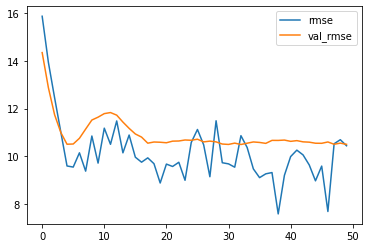

In [19]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()


<AxesSubplot:>

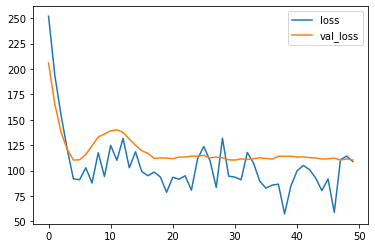

In [20]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()